In [142]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [163]:
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

from sqlalchemy import create_engine

from IPython.display import display_html

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

<IPython.core.display.Javascript object>

In [164]:
engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
house_prices_df = pd.read_sql_query("select * from houseprices", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_prices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


<IPython.core.display.Javascript object>

In [165]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

<IPython.core.display.Javascript object>

In [166]:
# Use ID as index
house_prices_df = house_prices_df.set_index("id")
house_prices_df.shape

(1460, 80)

<IPython.core.display.Javascript object>

In [167]:
house_prices_df.isna().mean().sort_values(ascending=False).head(10)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagetype      0.055479
garagecond      0.055479
garagefinish    0.055479
garagequal      0.055479
dtype: float64

<IPython.core.display.Javascript object>

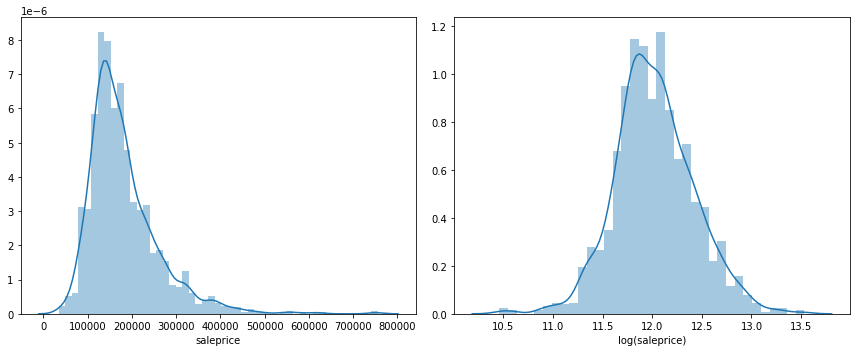

<IPython.core.display.Javascript object>

In [198]:
# Target variable is not normal, log transform is normal
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(house_prices_df["saleprice"], ax=axes[0])

sns.distplot(np.log(house_prices_df["saleprice"]), ax=axes[1])
axes[1].set_xlabel("log(saleprice)")

plt.tight_layout()
plt.show()

In [169]:
# Log transfrom dataframe
log_df = house_prices_df.copy()
log_df["log_saleprice"] = np.log(log_df["saleprice"])
log_df = log_df.drop(columns=["saleprice"])

<IPython.core.display.Javascript object>

In [170]:
corr_df = log_df.corr()[["log_saleprice"]]
corr_df.columns = ["corr"]
corr_df["abs_corr"] = corr_df.abs()
top_corrs = corr_df.sort_values("abs_corr", ascending=False).head(10)
top_corrs

,corr,abs_corr
log_saleprice,1.000000,1.000000
overallqual,0.817184,0.817184
grlivarea,0.700927,0.700927
garagecars,0.680625,0.680625
garagearea,0.650888,0.650888
totalbsmtsf,0.612134,0.612134
firstflrsf,0.596981,0.596981
fullbath,0.594771,0.594771
yearbuilt,0.586570,0.586570
yearremodadd,0.565608,0.565608


<IPython.core.display.Javascript object>

In [171]:
def plot_top_corrs(df, column, top_corrs_df, n=10):
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()

<IPython.core.display.Javascript object>

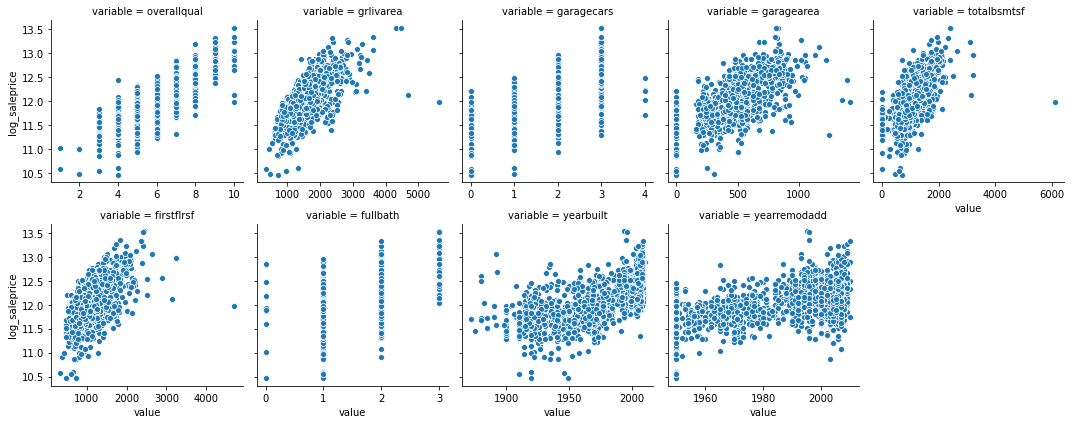

<IPython.core.display.Javascript object>

In [172]:
plot_top_corrs(log_df, "log_saleprice", top_corrs)

There appears to be some houses that sold for very low prices despite their features. Lets drop the 4 most expensive houses.

In [173]:
drop_ids = log_df.sort_values("firstflrsf", ascending=False).iloc[:4].index
print(f"Dropping house ids {list(drop_ids)}")
# log_df = log_df.drop(index=drop_ids)

Dropping house ids [1299, 497, 524, 1025]


<IPython.core.display.Javascript object>

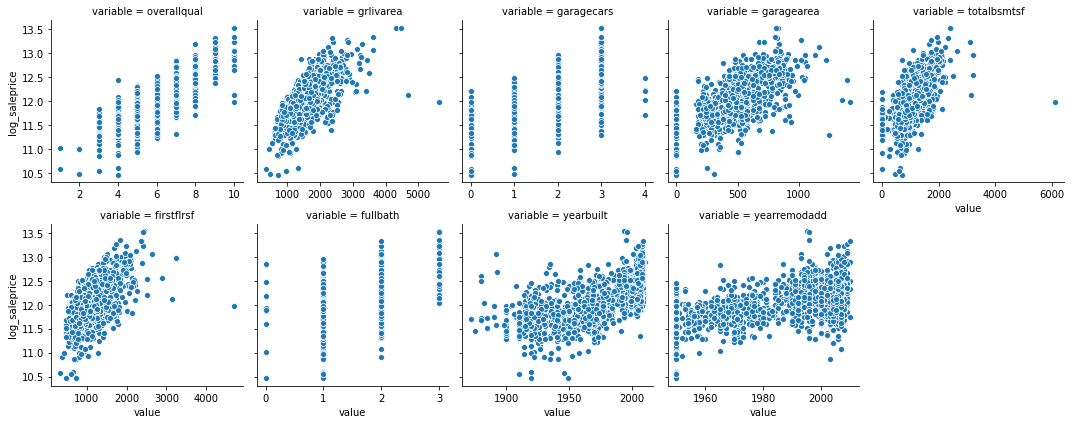

<IPython.core.display.Javascript object>

In [174]:
plot_top_corrs(log_df, "log_saleprice", top_corrs)

In [175]:
# Keep only top correlated columns
num_cols = log_df.select_dtypes("number").columns
keep_cols = top_corrs.index
drop_cols = [c for c in num_cols if c not in keep_cols]
log_df = log_df.drop(columns=drop_cols)
log_df

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagearea,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition,log_saleprice
id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,548,TA,TA,Y,None,None,None,WD,Normal,12.247694
2,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,460,TA,TA,Y,None,None,None,WD,Normal,12.109011
3,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,608,TA,TA,Y,None,None,None,WD,Normal,12.317167
4,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,642,TA,TA,Y,None,None,None,WD,Abnorml,11.849398
5,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,836,TA,TA,Y,None,None,None,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,460,TA,TA,Y,None,None,None,WD,Normal,12.072541
1457,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,500,TA,TA,Y,None,MnPrv,None,WD,Normal,12.254863
1458,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,252,TA,TA,Y,None,GdPrv,Shed,WD,Normal,12.493130


<IPython.core.display.Javascript object>

##### Handling nulls
* If columns with lots of nulls aren't very correlated with salesprice we can remove the columns.

In [176]:
corr_df = house_prices_df.corr()

<IPython.core.display.Javascript object>

In [177]:
corr_df["saleprice"]

mssubclass      -0.084284
lotfrontage      0.351799
lotarea          0.263843
overallqual      0.790982
overallcond     -0.077856
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.477493
bsmtfinsf1       0.386420
bsmtfinsf2      -0.011378
bsmtunfsf        0.214479
totalbsmtsf      0.613581
firstflrsf       0.605852
secondflrsf      0.319334
lowqualfinsf    -0.025606
grlivarea        0.708624
bsmtfullbath     0.227122
bsmthalfbath    -0.016844
fullbath         0.560664
halfbath         0.284108
bedroomabvgr     0.168213
kitchenabvgr    -0.135907
totrmsabvgrd     0.533723
fireplaces       0.466929
garageyrblt      0.486362
garagecars       0.640409
garagearea       0.623431
wooddecksf       0.324413
openporchsf      0.315856
enclosedporch   -0.128578
threessnporch    0.044584
screenporch      0.111447
poolarea         0.092404
miscval         -0.021190
mosold           0.046432
yrsold          -0.028923
saleprice        1.000000
Name: saleprice, dtype: float64

<IPython.core.display.Javascript object>

In [178]:
drop_cols = ["poolqc", "alley", "fence", "fireplacequ", "miscfeature"]
log_df = log_df.drop(columns=drop_cols)
log_df = log_df.dropna()

print(log_df.shape)
log_df.head()

(1338, 48)


,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,garagetype,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,saletype,salecondition,log_saleprice
id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Attchd,RFn,2,548,TA,TA,Y,WD,Normal,12.247694
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Attchd,RFn,2,460,TA,TA,Y,WD,Normal,12.109011
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Attchd,RFn,2,608,TA,TA,Y,WD,Normal,12.317167
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Detchd,Unf,3,642,TA,TA,Y,WD,Abnorml,11.849398
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Attchd,RFn,3,836,TA,TA,Y,WD,Normal,12.429216


<IPython.core.display.Javascript object>

##### Categorical variable analysis

In [179]:
cat_cols = log_df.select_dtypes("O").copy()
anova_results = []
for col in cat_cols:
    groups = list(log_df[["log_saleprice", col]].groupby(col))
    samples = [group[1]["log_saleprice"] for group in groups]
    f, p = stats.f_oneway(*samples)

    anova_result = {"col": col, "f": f, "p": p}
    anova_results.append(anova_result)

anova_results_df = pd.DataFrame(anova_results).sort_values("f", ascending=False)
top_f = anova_results_df.head(10)
top_f

,col,f,p
17,exterqual,371.336560,2.721252e-175
20,bsmtqual,362.389690,4.221643e-172
29,kitchenqual,352.895713,1.122393e-168
32,garagefinish,309.056384,4.991825e-111
19,foundation,134.180318,2.208245e-96
27,centralair,112.606943,2.591895e-25
26,heatingqc,98.211559,2.637966e-73
16,masvnrtype,95.262630,7.242995e-56
31,garagetype,93.156415,3.167353e-84
0,mszoning,71.611487,5.391324e-55


<IPython.core.display.Javascript object>

In [180]:
print(log_df.shape)

(1338, 48)


<IPython.core.display.Javascript object>

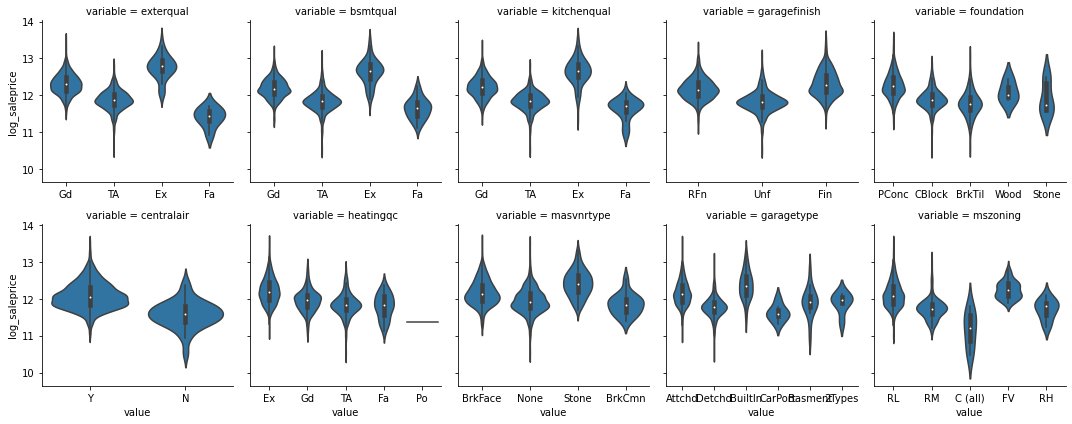

<IPython.core.display.Javascript object>

In [181]:
cat_cols = log_df.select_dtypes("O").copy()[top_f["col"]]
cat_cols["log_saleprice"] = log_df["log_saleprice"]

tall_cat_cols = pd.melt(cat_cols, "log_saleprice")

fg = sns.FacetGrid(tall_cat_cols, col="variable", col_wrap=5, sharex=False)
fg.map(sns.violinplot, "value", "log_saleprice")
plt.show()

Moving forward with `["exterqual", "bsmtqual", "kitchenqual", "centralair"]`, drop all other category columns.

In [182]:
print(log_df.shape)

(1338, 48)


<IPython.core.display.Javascript object>

In [183]:
cat_cols = log_df.select_dtypes("O").copy()
keep_cols = ["exterqual", "bsmtqual", "kitchenqual", "centralair"]
drop_cols = [c for c in cat_cols.columns if c not in keep_cols]

log_df = log_df.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

In [184]:
# Encode centralair as binary
log_df["centralair"] = (log_df["centralair"] == "Y").astype(int)

<IPython.core.display.Javascript object>

In [185]:
# Encode qual columns as ordinal
quality_map = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
log_df[["exterqual", "bsmtqual", "kitchenqual"]] = log_df[
    ["exterqual", "bsmtqual", "kitchenqual"]
].replace(quality_map)

<IPython.core.display.Javascript object>

In [186]:
print(log_df.shape)
log_df.head()

(1338, 14)


,overallqual,yearbuilt,yearremodadd,exterqual,bsmtqual,totalbsmtsf,centralair,firstflrsf,grlivarea,fullbath,kitchenqual,garagecars,garagearea,log_saleprice
id,,,,,,,,,,,,,,
1,7,2003,2003,3,3,856,1,856,1710,2,3,2,548,12.247694
2,6,1976,1976,2,3,1262,1,1262,1262,2,2,2,460,12.109011
3,7,2001,2002,3,3,920,1,920,1786,2,3,2,608,12.317167
4,7,1915,1970,2,2,756,1,961,1717,1,3,3,642,11.849398
5,8,2000,2000,3,3,1145,1,1145,2198,2,3,3,836,12.429216


<IPython.core.display.Javascript object>

In [193]:
X = log_df.drop(columns=["log_saleprice"])
y = log_df["log_saleprice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train = X
y_train = y

<IPython.core.display.Javascript object>

In [194]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [195]:
print_vif(log_df.drop(columns=["log_saleprice"]))

VIF results
-------------------------------
const           26303.094875
overallqual         3.321205
yearbuilt           3.324818
yearremodadd        2.234093
exterqual           2.935763
bsmtqual            2.905093
totalbsmtsf         6.088266
centralair          1.201788
firstflrsf          6.124382
grlivarea           2.699396
fullbath            2.257248
kitchenqual         2.585707
garagecars          3.969938
garagearea          3.595853
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [196]:
model = LinearRegression()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.8192598830174133
test_score: 0.798488978146517


<IPython.core.display.Javascript object>

In [197]:
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     461.6
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:28:34   Log-Likelihood:                 552.19
No. Observations:                1338   AIC:                            -1076.
Df Residuals:                    1324   BIC:                            -1004.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.2533      0.714      8.760      0.000       4.853       7.654
overallqual      0.0785      0.006     12.951      0.000       0.067       0.090
yearbuilt        0.0009      0.000      3.476      0.001       0.000       0.001
yearremodadd     0.0012      0.000      3.723      0.000       0.001       0.002
exterqual        0.0192      0.013      1.465      0.143      -0.007       0.045
bsmtqual         0.0461      0.011      4.199      0.000       0.025       0.068
totalbsmtsf  -1.107e-06   2.68e-05     -0.041      0.967   -5.37e-05    5.14e-05
centralair       0.1891      0.023      8.176      0.000       0.144       0.234
firstflrsf       0.0001   2.82e-05      4.481      0.000     7.1e-05       0.000
grlivarea        0.0002   1.39e-05     16.037      0.000       0.000       0.000
fullbath        -0.0121      0.012     -1.002      0.316      -0.036       0.012
kitchenqual      0.0440      0.011      4.063      0.000       0.023       0.065
garagecars       0.0638      0.014      4.611      0.000       0.037       0.091
garagearea    2.728e-05   4.47e-05      0.610      0.542   -6.04e-05       0.000
==============================================================================
Omnibus:                      875.356   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33512.857
Skew:                          -2.477   Prob(JB):                         0.00
Kurtosis:                      27.012   Cond. No.                     5.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [192]:
pred_df = X_test.copy()
pred_df["actual"] = np.exp(y_test)
pred_df = pred_df.reset_index()

pred_df["predicted"] = np.exp(model.predict(X_test))

pred_df["residual"] = pred_df["predicted"] - pred_df["actual"]
pred_df["abs_residual"] = pred_df["residual"].abs()
pred_df["perc_residual"] = pred_df["abs_residual"] / pred_df["actual"]

print(f'Mean Absolute Error: ${pred_df["abs_residual"].mean():.2f}')
print(f'Mean Absolute Percent Error: {pred_df["perc_residual"].mean() * 100:.2f}%')

Mean Absolute Error: $18748.13
Mean Absolute Percent Error: 11.55%


<IPython.core.display.Javascript object>